# Modeling

In this notebook, we will focus entirely on the 3D OCT volumes and leave the merged 2D image set for potential analysis in the future.  The objectives here will be first an attempt to replicate the building and training of the CNN built by the original authors of the dataset, and then to test out two different alternative architectures.

## Import Statements

In [1]:
# Custom Modules Import
import os,sys
sys.path.append(os.path.abspath('..'))
from octcv.arrViz import *
from octcv.mdl_lib import *

# Silence Benign Warnings
os.environ["KERAS_BACKEND"] = "tensorflow"     # stop Keras from probing other backends
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"       # 0=all, 1=INFO off, 2=+WARNING off, 3=+ERROR off
# Optional: disable oneDNN optimized kernels if you want bit-for-bit stability on CPU
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# General
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as iPyDisplay, Markdown as iPyMD

# Modeling (Tensorflow/Keras)
from visualkeras import layered_view
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.layers import Conv3D,Conv2D,Dense,MaxPool2D,MaxPool3D,Flatten,Dropout,\
BatchNormalization,GlobalAveragePooling3D,GlobalAveragePooling2D,ReLU,Input,Add
from keras.metrics import AUC
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Model as kerasModel

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve

2025-11-09 06:37:18.354387: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 06:37:18.363073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762688238.372379 2467482 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762688238.375514 2467482 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762688238.383298 2467482 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Loading Datasets

For the case of a unimodal CNN, the entirety of X will be the image data - however, to conserve RAM, will keep as filepaths for now and define a custom function to load the arrays for a given set during training -- this is done via a custom method `octcv.mdl_lib.xY_split()` which returns a `y_label`, `y`, and `X` in which `X` is an instance of the `XVolSet` class, meaning it stores the filepaths and the actual image arrays can be loaded simply via calling the `.load()` method of a given instance -- see help() or source code under `../octcv/mdl_lib.py` for more information.

In [2]:
#++++LOAD+DATA++++#
v_test = pd.read_csv('./volumes_TEST.csv')
v_train = pd.read_csv('./volumes_train.csv')

# 3D Volume Dataset
vy_labels, vy_test, vX_test = yX_split(v_test)
vy_train_labels, vy_train, vX_train = yX_split(v_train)
print(f"\n3D Volumes - train_test shapes:")
print(f"\tTrain Set(y,X): {vy_test.shape,vX_test.shape}")
print(f"\tTest Set(y,X): {vy_train.shape,vX_train.shape}")
print()


3D Volumes - train_test shapes:
	Train Set(y,X): ((222, 1), (222, 2))
	Test Set(y,X): ((888, 1), (888, 2))



### Validation-Test Split

As mentioned in the [original paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126), the dataset was divided into three different sets, with roughly

+ 80% training
+ 10% validation
+ 10% testing

Currently for this project, the data are divided into

+ 80% training
+ 20% testing

To rectify this, we will simply split our current "test set" of 222 datapoints in half -- i.e., two sets of 111 entries.  To distinguish from the original "test set", we will name them **validation** (`v_valid`) and **evaluation** (`v_eval`), where the validation set will be used in addition to the training set during model training, while the evaluation set will be used to assess model performance after training.

In [3]:
from sklearn.model_selection import train_test_split

v_valid,v_eval = train_test_split(v_test,test_size=0.5,random_state=42)
print(v_valid.shape,v_eval.shape)

(111, 8) (111, 8)


### Balancing Class Dsitributions 

As noted in earlier steps of this project (EDA), the class distribution is skewed, with glaucoma +ive data points over-represented compared to what one might find in the true population.  Nevertheless, the original authors of the dataset reported training on this dataset without any attempts to create a more representative dataset or at least balance it.  That said, for the sake of a CNN with the sole purpose of detecting the presence or absence of glaucoma based on ONH-centered OCT volumes, the model may prove to be quite useless if trained on data more representative of the true population, as its prevlance in the general population is technically a small minority ( 0.57% - 1.62% per [JAMA](https://jamanetwork.com/journals/jamaophthalmology/fullarticle/2824476) ).  As a result, it may be more important for the model to be fed a large amount of data that conveys the unique visual nuances of scans depicting eyes with glaucoma.  

Given this, we will proceed with modeling using the data as is, while keeping the option to go back and cut out some excess glaucoma +ive data points to create a more balanced the class distribution should anything go wrong with the modeling steps down the line. 

In [4]:
# def balance_dataset(df,class_column='dx_class', report=False,random_seed=None):

#     unique_classes = df[class_column].unique()
    
#     a,b = unique_classes
    
#     adf = df[ df[class_column] == a ]
#     bdf = df[ df[class_column] == b ]

#     if len(adf) > len(bdf):
#         large_subdf = pd.DataFrame(adf)
#         small_subdf = pd.DataFrame(bdf)
#     elif len(bdf) > len(adf):
#         large_subdf = pd.DataFrame(bdf)
#         small_subdf = pd.DataFrame(adf)

#     # Randomly sample from large subdataframe the same number of rows in the small subdataframe
#     if random_seed:
#         np.random.seed(random_seed)
        
#     indices = set()
#     while len(indices) < len(small_subdf):
#     	indices.update([np.random.choice(large_subdf.index)])
#     indices = np.array(list(indices))

#     large_subdf = large_subdf.reset_index()
#     reduced_subdf = large_subdf[large_subdf['index'].isin(indices)].drop('index',axis=1)
#     balanced_df = pd.concat([small_subdf,reduced_subdf],axis=0)

#     if report:
#         print(f"Shape Change: {df.shape} --> {balanced_df.shape}")
#         print('='*40)
#         print(f"Original Class Distribution:\n{df.value_counts(class_column)}")
#         print('-'*40)
#         print(f"Balanced Class Distribution:\n{balanced_df.value_counts(class_column)}")
#         print('_'*40,'\n')
#     return balanced_df

# print(f"\033[1;4;32m___TEST_SET___\033[0m RE-BALANCING")
# vTestBalanced = balance_dataset(v_test,report=True,random_seed=42)
# print(f"\033[1;4;31m___TRAINING_SET___\033[0m RE-BALANCING")
# vTrainBalanced = balance_dataset(v_train,report=True,random_seed=42)

In [5]:
def yX_split(df,one_hot_drop=True,summary_report=False):
    '''
    Splits datasets into y and X, along with y_labels (strings) for downstream interpretation.

    PARAMS:
    -------
    df    :    DataFrame, formated per OCTCV project pre-processing
    one_hot_drop: bool, if True, will drop extra column in y
    summary_report : bool, if True, will print a summary of return value stats

    RETURNS:
    --------
    (y_labels, y, X)    :     tuple

        y_labels        :     numpy.ndarray of shape (N,) with class labels in human-readable / string format for interpretation of results after fitting/training
        y               :     numpu.ndarry of shape (N,2) with hot-one encoded numeric class labels
                                    column 0 --> "glaucoma" (1 if True, 0 if False)
                                    column 1 --> "normal" (1 if True, 0 if False)
        X               :     XVolSet() instance -- contains both normalized & display image filepaths (column 0 and 1, respectively)
                                    actual image data accessible via .load() method
    '''
    # Subset class labels for ease of interpretation later on
    y_labels = df.dx_class.values
    
    # Subset numeric class target variable (`glaucoma` column of df)
    yvals = df.glaucoma.values
    # Recreate `normal` column that was dropped during one-hot encoding
    yinv =  (df.glaucoma - 1).abs().values # `yinv` for "y-inverted"
    # Combine columns into one  for y
    y = np.stack((yvals,yinv),axis=1) # shape: (N,2) where N = len(df)
    if one_hot_drop:
        y = y[:,0].reshape(-1,1)        

    # Get both the normalized image paths and the display images paths
    disp_col = [ c for c in df.columns if c.startswith('display') ][0] # can be useful for visualization later on
    X_paths = df[['normalized_array',disp_col]] # "normalized_array" part for training / inference
    X = XVolSet(X_paths)

    if summary_report:
        print(f"y_labels shape: {y_labels.shape}")
        print(f"y shape: {y.shape}")
        print(f"X shape {X.shape}")
        
    return y_labels, y, X

y_valid_labels, y_valid, X_valid = yX_split(v_valid,summary_report=True)
y_eval_labels, y_eval, X_eval = yX_split(v_eval,summary_report=True)
y_train_labels, y_train, X_train = yX_split(v_train,summary_report=True)

y_labels shape: (111,)
y shape: (111, 1)
X shape (111, 2)
y_labels shape: (111,)
y shape: (111, 1)
X shape (111, 2)
y_labels shape: (888,)
y shape: (888, 1)
X shape (888, 2)


## Architectures

Here, we define three different model architectures using the functional API in Keras/TensorFlow.

+ **MODEL 1 :**  *An attempt at replicating the original model, as described in the original paper.*

    + Defined within `buildSequential()`

---

+ **MODEL 2 :**  *A ResNet like architecture, building upon some of the basic elements of Model 1, but with the introduction of a **residual block**.*

    + Defined within `buildResNet()`

---

+ **MODEL 3 :**  *An attention-based architecture, building upon the previous two models, that utilizes both **squeeze-excitation** and **spatial-attention** blocks.*

    + Defined within `buildAttnNN()`


In [6]:
# MODEL 1 : ORIGINAL SEQUENTIAL
def buildSequential(input_shape=(64,128,64,1),
                    activation='sigmoid',
                    n_classes=1,
                    model_name='original'):
    
    if activation == 'sigmoid':
        n_classes = 1

    def conv3D_block(n_channels, kernel_size,strides=1, padding='same', layer_name=None):
        if layer_name: 
            cname = f"BLOCK{layer_name}_Conv3D"
            bname = f"BLOCK{layer_name}_BatchNorm"
            rname = f"BLOCK{layer_name}_ReLU"
        else:
            cname,bname,rname = None,None,None
            
        layer_list = [
            Conv3D(filters = n_channels,
                   kernel_size = kernel_size,
                   strides = strides,
                   padding = padding,
                   name = cname),
            BatchNormalization(name=bname),
            ReLU(name=rname)
        ]

        return layer_list

    kernelSizeSeq = [ 7,5,5,3,3 ]
    strideSeq = [ 2,1,1,1,1 ]
    
    five_Conv3D_blocks = [ ]
    for i,(k,s) in enumerate(zip(kernelSizeSeq,strideSeq)):
        five_Conv3D_blocks.extend( conv3D_block(32,k,s,layer_name=str(i+1))  )
        
    # Instantiate sequential model with architecture matching that described in paper
    return Sequential([

        # Input Layer
        Input(shape=input_shape),

        # Five Main Blocks, each involving Conv3D,BatchNormalization,and ReLU 
        *five_Conv3D_blocks,

        # Global Average Pooling
        GlobalAveragePooling3D(name='GlobalAveragePooling3D'),
    
        # Dense → Softmax (for multi-class CAM support)
        Dense(n_classes, activation=activation, name='Dense')  # use 1 + sigmoid if binary
    ], name = f"{model_name}_sequential")

In [7]:
# MODEL 2: RESNET-LIKE
    
def buildResNet(input_shape=(64, 128, 64, 1), 
                activation='sigmoid',n_classes=1,
                name='ResNetLike'):
    
    def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
        shortcut = x
        
        # First convolution
        x = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        # Second convolution
        x = Conv3D(filters, kernel_size=kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        
        # Handle potential shape mismatch for the skip connection
        # This occurs when strides > 1
        if strides != 1:
            shortcut = Conv3D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        
        # Add the skip connection to the main path
        x = Add()([x, shortcut])
        x = ReLU()(x)
        
        return x
        
    def build_resnet_like_model(input_shape=input_shape,
                                activation=activation,
                                n_classes=n_classes,
                                name=name):
        
        if activation == 'sigmoid':
            n_classes = 1
        
        inputs = Input(shape=input_shape)
        
        # Initial layer: reduced filters and larger kernel
        x = Conv3D(16, kernel_size=5, strides=2, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        # Residual Block 1: No change in spatial dimensions
        x = residual_block(x, filters=16, strides=1)
        
        # Residual Block 2: Reduce spatial dimensions with stride 2
        x = residual_block(x, filters=32, strides=2)
        
        # Residual Block 3: No change in spatial dimensions
        x = residual_block(x, filters=32, strides=1)
    
        # Global Average Pooling
        x = GlobalAveragePooling3D()(x)
        
        # Dense layer for classification
        outputs = Dense(n_classes, activation=activation)(x)
        
        # Create and return the model
        return kerasModel(inputs, outputs,name=name)

    return build_resnet_like_model()

In [8]:
# MODEL 3: ATTENTION

from keras import ops as K

def buildAttnNN(input_shape=(64,128,64,1),
                activation='sigmoid', n_classes=1, 
                name='Attention'):
    
    if activation == 'sigmoid':
        n_classes = 1
        
    def se_block(x, r=16):
        c = x.shape[-1]
        s = layers.GlobalAveragePooling3D()(x)             # (B, C)
        s = layers.Dense(max(c // r, 4), activation='relu')(s)
        s = layers.Dense(c, activation='sigmoid')(s)
        s = layers.Reshape((1, 1, 1, c))(s)
        return layers.Multiply()([x, s])
    
   
    def spatial_attention(x, k=7):
        """Lightweight spatial attention for 3D (CBAM-style with avg+max)."""
        # channel-wise avg & max → concat → 3D conv → sigmoid mask
        avg = K.mean(x, axis=-1, keepdims=True)
        mx  = K.max(x,  axis=-1, keepdims=True)
        m   = layers.Concatenate(axis=-1)([avg, mx])           # (B,D,H,W,2)
        m   = layers.Conv3D(1, kernel_size=k, padding='same', activation='sigmoid')(m)
        return layers.Multiply()([x, m])
    
    def residual_block_attn(x, filters, kernel_size=3, strides=1,
                      use_se=True, se_r=16,
                      use_spatial=False, spatial_kernel=7):
        
        shortcut = x
    
        # Residual branch
        y = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
        y = BatchNormalization()(y)
        y = ReLU()(y)
    
        y = Conv3D(filters, kernel_size=kernel_size, padding='same')(y)
        y = BatchNormalization()(y)
    
        # Optional attention on residual branch *before* addition
        if use_se:
            y = se_block(y, r=se_r)
        if use_spatial:
            y = spatial_attention(y, k=spatial_kernel)
    
        # Skip path if shape changes
        if strides != 1 or shortcut.shape[-1] != filters:
            shortcut = Conv3D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
    
        out = Add()([y, shortcut])
        out = ReLU()(out)
        return out

    def build_resnet_like_model_attn(input_shape=input_shape, 
                                     activation=activation,
                                     n_classes=n_classes,
                                     use_spatial_last=True,
                                     name=name):
        
        inputs = Input(shape=input_shape)
    
        x = Conv3D(16, kernel_size=5, strides=2, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)
    
        # Stage 1 (larger maps): SE only
        x = residual_block_attn(x, filters=16, strides=1, use_se=True, use_spatial=False)
    
        # Stage 2: downsample; SE only
        x = residual_block_attn(x, filters=32, strides=2, use_se=True, use_spatial=False)
    
        #x = residual_block_attn(x, filters=32, strides=2, use_se=True, use_spatial=False)
    
        # Stage 3 (smaller maps): SE + optional spatial
        x = residual_block_attn(x, filters=32, strides=1, use_se=True,
                              use_spatial=use_spatial_last, spatial_kernel=7)
    
        x = GlobalAveragePooling3D()(x)
    
        outputs = Dense(n_classes, activation=activation)(x)
    
        return kerasModel(inputs, outputs, name=name)

    return build_resnet_like_model_attn()
    

In [9]:
def show_architecture(model,
                      show_dimension=True,
                      legend=True,
                      type_ignore=[BatchNormalization,ReLU],
                      sizing_mode='balanced',
                      ax=None,
                      figsize=(8,4)
                     ):
    
    img = layered_view(model=model,
             show_dimension=show_dimension,
             legend=legend,
             type_ignore=type_ignore,
             sizing_mode=sizing_mode
            )
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=figsize)
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(f"Model Architecture: {model.name}\n")

In [10]:
def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = bool(layer_index%2)

    # Get the output shape of the layer
    if hasattr(layer, 'output_shape'):
        # ───────────────────────────────
        # Legacy Keras (standalone 2.x) or TF-Keras <2.11
        # ───────────────────────────────
        # this will work so long as `layer.output_shape` exists
        output_shape = [x for x in list(layer.output.shape) if x is not None]
    else:
        # ───────────────────────────────
        # Modern TF-Keras (>= 2.11) – attribute removed
        # ───────────────────────────────
        output_shape = list(layer.output.shape)

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn    
    output_shape_txt = ""

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2: # Add an x between dimensions, e.g. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 2: # Add a newline between the last two dimensions, e.g. 3x3 \n 64
            output_shape_txt += "\n"

    # Add the name of the layer to the text, as a new line
    output_shape_txt += f"\n{layer.name}"

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above
    
def displayArchitecture(dummy_layer_spacing=50,
                        show_dimension=True,
                        legend=False,
                        sizing_mode='balanced',
                        ignore_layers=[BatchNormalization,ReLU],
                        text_callable=text_callable,
                        save_to_file=None,
                        figsize=(8,4),
                        ax=None,
                        **kwargs
                        ):
    font_prop = font_manager.FontProperties(family='sans-serif',weight='bold')
    font_path = font_manager.findfont(font_prop)
    font = ImageFont.truetype(font_path,size=15)

    model.add(vk.SpacingDummyLayer(spacing=dummy_layer_spacing))

    if save_to_file:
        if type(save_to_file) == bool:
            save_to_file = f"{model.name}_architecture.png"

    
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=figsize)

    img = vk.layered_view(model,
                    show_dimension=show_dimension,
                    legend=legend,
                    type_ignore=ignore_layers,
                    text_callable=text_callable,
                    sizing_mode=sizing_mode,
                    to_file=save_to_file,
                    font=font,
                    **kwargs
                    )

    ax.axis('off')
    ax.imshow(img)
    ax.set_title(f"Model Architecture: {model.name}\n")

# import visualkeras as vk
# vk.layered_view(model,
#                 text_callable=text_callable,
#                 show_dimension=True,
#                 type_ignore=[BatchNormalization,ReLU],
#                 sizing_mode='balanced'
#                )

## Training & Evaluation

For the sake of a cleaner looking notebook, a custom class `octcv.mdl_lib.ModelEvaluator` was written and imported here.  The class takes in a model architecture as defined via Keras/TensorFlow functional API, along with all three datasets (training, validation, and evaluation).  Here, we mainly use the method `.train_and_evaluate()` which automates a variety of actions we will want in every instance of model training and evaluation, including:

1. Model Training -- aside from the model architecture itself, various aspects of the setup for model training will remain constant:
   + Early Stopping Conditions:
       + Monitoring Metric: validation AUC
       + `Patience = 3`
       + `restore_best_weights=True`
   + Compling the model (i.e., `model.compile()`) with the following arguments:
       + Optimizer: `NAdam`
           + learning rate: $10^{-4}$
       + Metrics: accuracy, AUC
       + Loss Function: Binary Cross-entropy
   + Running model training (i.e., `model.fit()`) using
       + `v_train`, split into y and X, including loading of the actual image arrays of X at the moment of training (as discussed earlier).
       + `v_valid` as the validation set, splitting into y and X with "point-of-training" loading as well.
       + 100 maximum epochs, with early stopping conditions passed in
       + Saving training history to variable for later use
   + Plotting of both training & validation AUC over time (by epoch number).
     
2. Model Evaluation
   + Generating novel predicted probabilities using `X_eval` (e.g., `y_prob = model.predict(X_eval.load())`)
   + Testing out different prediction thresholds between 0 and 1, above which the positive class (Glaucoma/POAG) is predicted and below which the negative class (Healthy/Normal) is predicted, and comparing the resulting predictions to the true class allocations `y_eval` until an optimal threshold is determined. 
   + Plotting the associated ROC curve that represents the sensitivity and specificity of predictions across all of these thresholds.
   + Plotting a confusion matrix based on predictions generated using the best threshold.

For more information on the `ModelEvaluator` class, see the source code located at [`OCTCV/octcv/mdl_lib.py`](../octcv/mdl_lib.py).


In [11]:
verbosity=1

### 1. Original Model 

#### Building & Architecture Visualization

/home/etudie/anaconda3/lib/python3.12/site-packages/visualkeras/layered.py:231: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


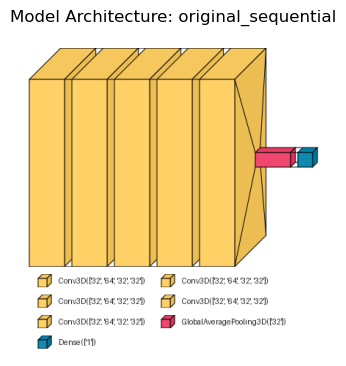

In [12]:
model = buildSequential()
me = ModelEvaluator(buildSequential(),
                    v_train,v_valid,v_eval)

me.vkPlotArchitecture()

#### Training

In [13]:
me.train(batch_size=4,verbose=verbosity)

Training model: original_sequential

BEGIN: 2025-11-09 06:37:19

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/100


I0000 00:00:1762688246.526175 2467640 service.cc:152] XLA service 0x79bd2402c9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762688246.526205 2467640 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-11-09 06:37:26.603574: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762688246.754182 2467640 cuda_dnn.cc:529] Loaded cuDNN version 90700


  5/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.3208 - auc: 0.7118 - loss: 0.7791

I0000 00:00:1762688249.796942 2467640 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.6425 - auc: 0.6531 - loss: 0.6148 - val_accuracy: 0.7387 - val_auc: 0.3877 - val_loss: 0.5984
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7844 - auc: 0.7239 - loss: 0.5123 - val_accuracy: 0.7387 - val_auc: 0.5017 - val_loss: 0.6016
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7779 - auc: 0.7422 - loss: 0.4948 - val_accuracy: 0.7387 - val_auc: 0.7595 - val_loss: 0.5761
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7752 - auc: 0.7609 - loss: 0.4851 - val_accuracy: 0.7477 - val_auc: 0.8276 - val_loss: 0.5064
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7940 - auc: 0.7773 - loss: 0.4714 - val_accuracy: 0.7838 - val_auc: 0.8598 - val_loss: 0.4463
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7943 - auc: 0.7906 - loss: 0.4591 - val_accuracy: 0.6306 - val_auc: 0.8562 - val_loss: 0.6326
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━

#### Evaluation

Evaluating model: original_sequential

Training Time: 3 minutes, 32 seconds, 159377 microseconds
----------------------------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.840000,0.677419,0.750000,31.000000
1,0.883721,0.950000,0.915663,80.000000
accuracy,0.873874,0.873874,0.873874,0.873874
macro avg,0.861860,0.813710,0.832831,111.000000
weighted avg,0.871511,0.873874,0.869397,111.000000


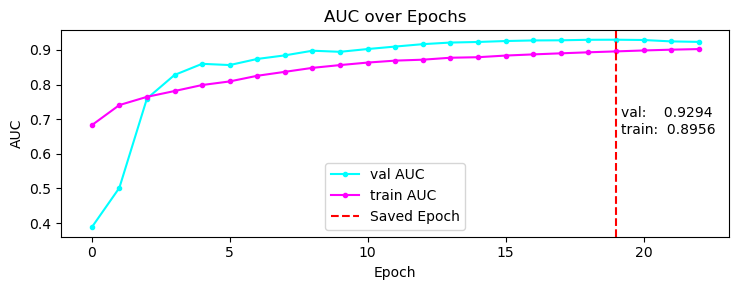

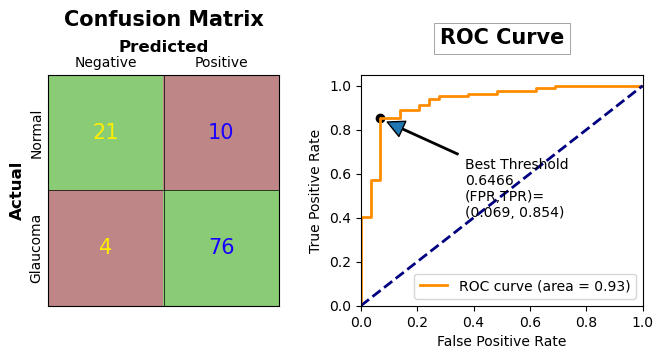

In [14]:
me.evaluate()

### 2. ResNetLike 

#### Building & Architecture

/home/etudie/anaconda3/lib/python3.12/site-packages/visualkeras/layered.py:231: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


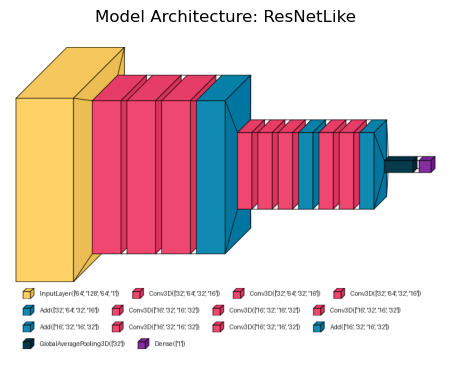

In [15]:
model = buildResNet()
me = ModelEvaluator(model,v_train,v_valid,v_eval)
me.vkPlotArchitecture()

#### Training

In [16]:
me.train(batch_size=4,verbose=verbosity)

Training model: ResNetLike

BEGIN: 2025-11-09 06:41:00

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5117 - auc: 0.6351 - loss: 0.8693 - val_accuracy: 0.7387 - val_auc: 0.6602 - val_loss: 0.5774
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7593 - auc: 0.7288 - loss: 0.4980 - val_accuracy: 0.7387 - val_auc: 0.2681 - val_loss: 0.6941
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7790 - auc: 0.7394 - loss: 0.4799 - val_accuracy: 0.7387 - val_auc: 0.5172 - val_loss: 0.7813
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7881 - auc: 0.7558 - loss: 0.4674 - val_accuracy: 0.7387 - val_auc: 0.7706 - val_loss: 0.6879
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7923 - auc: 0.7797 - loss: 0.4524 - val_accuracy: 0.7387 - val_auc: 0.8297 - val_loss: 0.6191
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8090 - auc: 0

#### Evaluation

Evaluating model: ResNetLike

Training Time: 1 minute, 6 seconds, 195136 microseconds
--------------------------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.666667,0.774194,0.716418,31.000000
1,0.906667,0.850000,0.877419,80.000000
accuracy,0.828829,0.828829,0.828829,0.828829
macro avg,0.786667,0.812097,0.796919,111.000000
weighted avg,0.839640,0.828829,0.832455,111.000000


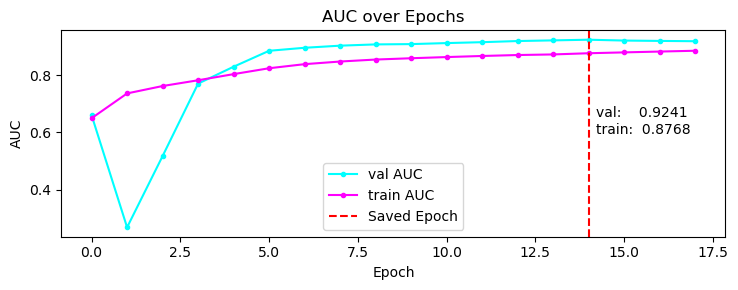

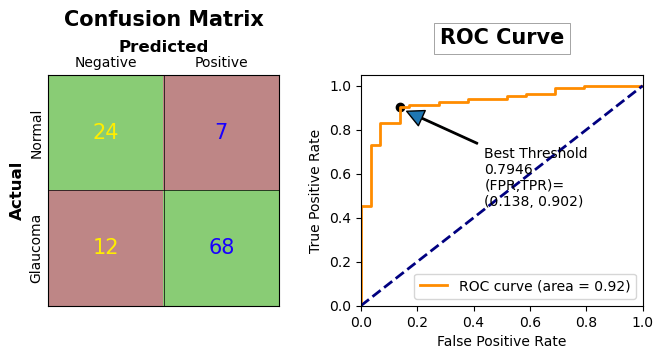

In [17]:
me.evaluate()

### 3. Attention: Squeeze-Excitation & VisualAttention  

#### Building & Architecture

/home/etudie/anaconda3/lib/python3.12/site-packages/visualkeras/layered.py:231: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


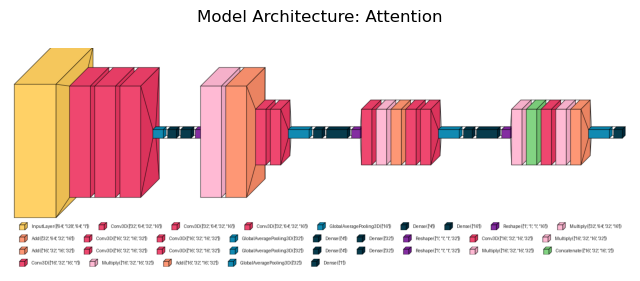

In [18]:
model = buildAttnNN()
me = ModelEvaluator(model,v_train,v_valid,v_eval)
me.vkPlotArchitecture()

#### Training

In [19]:
me.train(batch_size=4,verbose=verbosity)

Training model: Attention

BEGIN: 2025-11-09 06:42:10

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7677 - auc: 0.6851 - loss: 0.5449 - val_accuracy: 0.7387 - val_auc: 0.4277 - val_loss: 0.7458
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7713 - auc: 0.7428 - loss: 0.4818 - val_accuracy: 0.7387 - val_auc: 0.5191 - val_loss: 1.4312
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7867 - auc: 0.7646 - loss: 0.4629 - val_accuracy: 0.7387 - val_auc: 0.8326 - val_loss: 0.5750
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7909 - auc: 0.7860 - loss: 0.4483 - val_accuracy: 0.8198 - val_auc: 0.8682 - val_loss: 0.4385
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7993 - auc: 0.8085 - loss: 0.4355 - val_accuracy: 0.8108 - val_auc: 0.8877 - val_loss: 0.4643
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8055 - auc: 0

#### Evaluation

Evaluating model: Attention

Training Time: 1 minute, 30 seconds, 781587 microseconds
---------------------------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.807692,0.677419,0.736842,31.000000
1,0.882353,0.937500,0.909091,80.000000
accuracy,0.864865,0.864865,0.864865,0.864865
macro avg,0.845023,0.807460,0.822967,111.000000
weighted avg,0.861502,0.864865,0.860985,111.000000


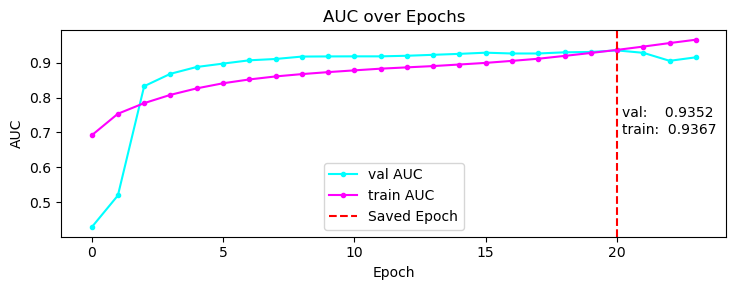

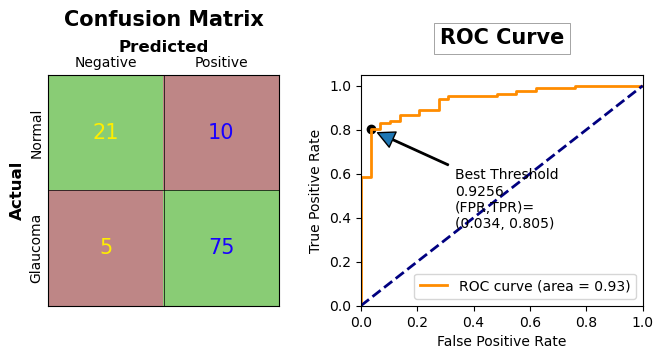

In [20]:
me.evaluate()

[[21 10]
 [ 5 75]]
----------------
TN:21, FP:10
FN:5, TP:75
----------------
[[ 21  10  31]
 [  5  75  80]
 [ 26  85 111]]

Precision = PPV = 75/85 = 	 0.8824

Recall = TPR = Sensitivity = 75/80 =  0.9375


Text(0.5, 0.44, '$\\frac{\\text{TP}}{\\text{TP}+\\text{FN}}$')

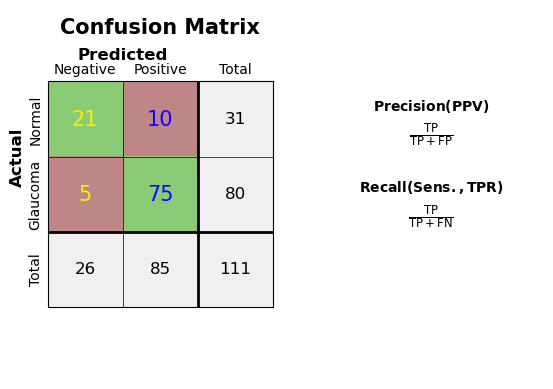

In [21]:

cm = confusion_matrix(me.y_true,me.y_pred)
print(cm)
tn,fp,fn,tp = cm.ravel()

print(f"----------------")
print(f"TN:{tn}, FP:{fp}")
print(f"FN:{fn}, TP:{tp}")
print(f"----------------")

cm = np.hstack((cm,cm.sum(axis=1).reshape(-1,1)))
cm = np.vstack((cm,cm.sum(axis=0).reshape(1,-1)))
print(cm)

ppv = cm[1,1] / cm[2,1]
print(f'\nPrecision = PPV = {cm[1,1]}/{cm[2,1]} = \t',round(ppv,4))

tpr = cm[1,1] / cm[1,2]
print(f'\nRecall = TPR = Sensitivity = {cm[1,1]}/{cm[1,2]} = ',round(tpr,4))



fig,(l,r) = plt.subplots(1,2)

me.plotCM(sum_classes=True,ax=l)
r.axis('off')

precision_text1 = r"$\mathbf{Precision} \mathbf{(PPV)}$"
precision_text2 = r"$\frac{\text{TP}}{\text{TP}+\text{FP}}$"
r.text(0.5, 0.74, precision_text1, fontsize=10, ha='center', va='center')
r.text(0.5, 0.66, precision_text2, fontsize=12, ha='center', va='center')

recall_text1 = r"$\mathbf{Recall} \mathbf{(Sens.,TPR)}$"
recall_text2 = r"$\frac{\text{TP}}{\text{TP}+\text{FN}}$"
r.text(0.5, 0.52, recall_text1, fontsize=10, ha='center', va='center')
r.text(0.5, 0.44, recall_text2, fontsize=12, ha='center', va='center')



